### Обобщающая способность: отложенная выборка + валидация

- тренировочные данные для нескольких моделей
- валидационные - для выбора модели
- тестовые - для проверки выбранной модели

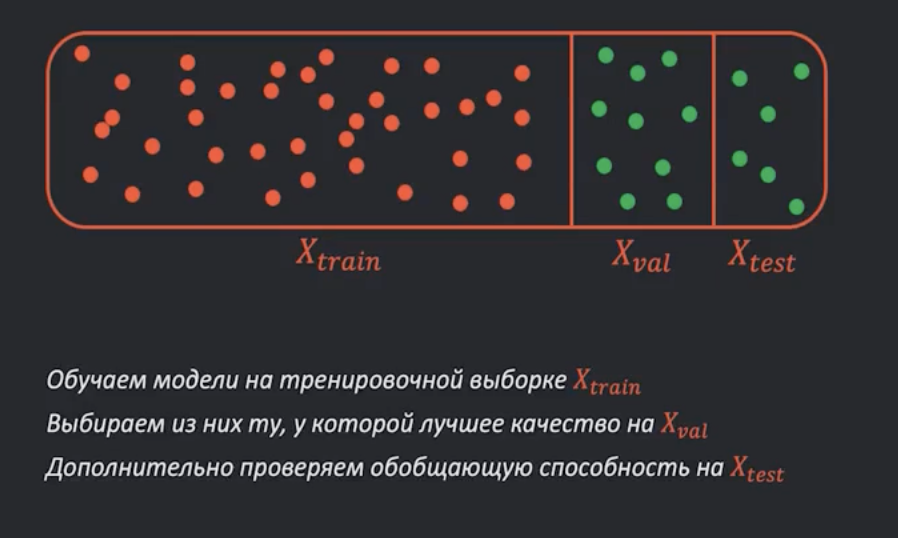

## Кросс-валидация


1. Делим исходные данные на k фолдов (частей) примерно одинаково размера.
2. Затем на (k - 1) блоке обучаем модели, а оставшуюся часть используем для тестирования.
3. Повторяем процедуру k раз, при этом на каждой итерации для проверки выбирается новый блок, а обучение производится на оставшихся.
4. Замеряем k средних ошибок на валидационной выборке (ее мы отложили ранее), и если их среднее/их распределение нас устраивает, то строим финальную модель.
5. фин модель:
- Либо выбрать лучшую модель, обучить её на всём объеме данных и потом замерить её качество на валидации. 
- Либо усреднить все модели, которые получаются во время кросс-валидации. 
- Либо выбрать ту модель, которая лучше всего справилась с данными на валидации.
При небольшом числе разбиений оценки будут смещенными, поскольку размер обучения будет существенно отличаться от размера полной выборки, и обученные в процессе кросс-валидации алгоритмы могут иметь более низкое качество. Дисперсия оценок будет небольшой.
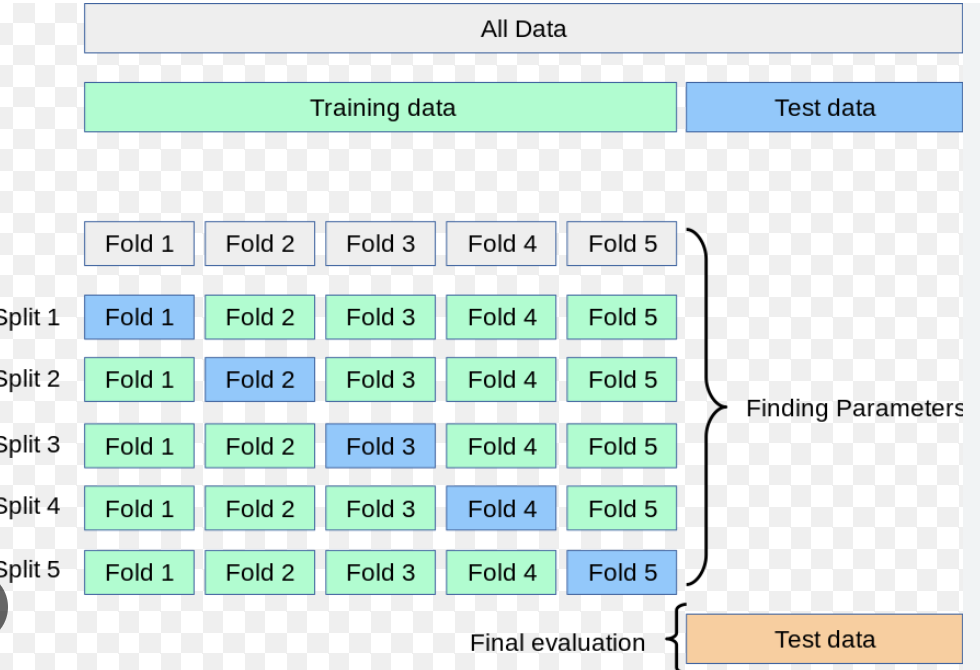

In [ ]:
### разбивка данных на train и test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

In [5]:
### линейная модель без интерсепта
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(X_train, Y_train)

LinearRegression(fit_intercept=False)

In [ ]:
### Метод KFOLD кросс-валидации
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=33)
kf.get_n_splits() # количество фолдов
kf.split(x) # разделение выборки - генератор индексов для тренировочных и вал данных (в данном случае 10 списков)

In [ ]:
x.values # np-массив с данным из pd 

In [ ]:
# обучаем модель на разделенных данных

losses_test = []
losses_train = []

for train_index, test_index in kf.split(x):
    X_train, X_test = x.values[train_index], x.values[test_index]
    Y_train, Y_test = y.values[train_index], y.values[test_index]
    
    model = LinearRegression()
    model.fit(X_train, Y_train)
    
    losses_test.append(np.mean((model.predict(X_test)-Y_test)**2)**(1/2))
    losses_train.append(np.mean((model.predict(X_train)-Y_train)**2)**(1/2))

In [ ]:
# кросс-валидация через sklearn
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    model, # LinearRegression()         
    X_train,           
    y_train,           
    cv= splitter #KFold(n_splits=10, shuffle=True, random_state=33),           
    scoring='neg_mean_squared_error', #typy of error
    return_train_score=False
)
np.mean(cv_results['test_score']) # cross-validate error

In [ ]:
# сравниваем ошибку на кросс-валидации для тестовых и для тренировочных данных

np.mean(losses_train)
np.mean(losses_test)


In [ ]:
# подсчет ошибки через sklearn
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, model.predict(X_test))

### для подсчета MSLE достаточно логорифмировать таргет

$$\text{MSLE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2$$

```
initial_data = initial_data.assign(log_trip_duration=np.log1p(initial_data['trip_duration']))
initial_data = initial_data.drop('trip_duration', axis=1)
# log1p(y) == log(y+1)
```


#### Объяснение:

Пусть имеем модель $a(x)$, обученную на MSE от $y$:
$$
\text{MSE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(y_i - a(x_i)\big)^2 \rightarrow min
$$

Также представим модель $a^*(x)$, обученную на MSE от $\log{(y + 1)}$:
$$
\text{MSE}(X, \log{(y+1)}, a^*) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - a^*(x_i)\big)^2 \rightarrow min
$$

Так как вторая модель старается аппроксимироваться ответы в виде $a^*(x) \approx \log{(y+1)}$, то для того, чтобы получить изначальные таргеты, необходимо выходы $a^*(x)$ проэкспоненцировать в виде следующего отношения: $a(x) = e^{a^*(x)} - 1$, то есть $a^*(x) = \log{(a(x) + 1)}$, где $a^*(x)$ дает логарифмические выходы, а $a(x)$ - изначальные. Подставим данное соотношение в MSE выше, получим:

$$
\text{MSE}(X, \log{(y+1)}, \log{(a(x) + 1)}) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$

когда K оказывается максимальным, а именно равным количеству объектов в выборке (каждый раз в валидации у нас 1 новый объект), то такой метод Кросс-Валидации еще называют **LeaveOneOut**

### Кросс-валиация для сравнения моделей

например, обучение модели на другом количестве фичей или другая сложность модели (полиномиальная)